# Global monthly temperature records in ERA5
Where have monthly average temperatures broken records across the world in 2020?

![Global Temperature records 2020](../graphs/Global_Animation_01.gif "Records2020")

In this first section, we load required packages and modules

In [29]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

#for rank calculation
import bottleneck

In [3]:
## this is to load our own function to retrieve ERA5,
## which is located in ../src/CDSretrieve.py
import sys
sys.path.append('../')

In [4]:
##And here we load the module
import src.CDSretrieve as retrieve

In [5]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

## Download ERA5

This section describes the retrieval of ERA5.
We retrieve netcdf files of global monthly 2m temperature and 2m dewpoint temperature for each year over 1979-2020. 

In [39]:
retrieve.retrieve_ERA5(variables = ['2m_temperature','2m_dewpoint_temperature'], folder = '../Siberia_example/')
;

''

We load all files with xarray `open_mfdataset`. The latest 3 months in this dataset are made available through ERA5T, which might be slightly different to ERA5.
In the downloaded file, an extra dimenions 'expver' indicates which data is ERA5 (`expver = 1`) and which is ERA5T (`expver = 5`). 
After retrieving and loading, I combine both ERA5 and ERA5T to create a dataset that runs until August 2020.


In [10]:
ERA5 = xr.open_mfdataset('../Siberia_example/ERA5_????.nc',combine='by_coords') ## open the data
ERA5# 

,Array,Chunk
Bytes,260.64 MB,6.26 MB
Shape,"(500, 181, 360, 2)","(12, 181, 360, 2)"
Count,209 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,260.64 MB,6.26 MB
Shape,"(500, 181, 360, 2)","(12, 181, 360, 2)"
Count,209 Tasks,42 Chunks
Type,float32,numpy.ndarray


In [14]:
ERA5_combine =ERA5.sel(expver=1).combine_first(ERA5.sel(expver=5))
ERA5_combine.load()

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 500)
Coordinates:
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-08-01
Data variables:
    t2m        (time, latitude, longitude) float32 244.7074 ... 214.79857
    d2m        (time, latitude, longitude) float32 241.76836 ... 211.0198
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-07 10:14:42 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Calculating the rank

We want to show for each month whether the recorded monthly average temperature for 2020 is the highest since 1979 (or second highest, etc.). 

We first select only January months.

In [15]:
ERA5_jan = ERA5_combine.sel(time=ERA5_combine['time.month'] == 1) ## Select only for the i month

Then we calculate the rank of January average temperatures over the years. We rename the variable 't2m' into 'Temperature rank'. 

In [16]:
ERA5_jan_rank = ERA5_jan['t2m'].rank(dim = 'time')
ERA5_jan_rank = ERA5_jan_rank.rename('Temperature rank')

We now have calculated the rank in increasing order, i.e. the highest values has the highest rank. 
However, we want to show the highest rank being number 1, the second highest being number 2. Therefore, we invert the ranks 
and then we select the inverted rank of January 2020 average temperature within the January average temperatures of the other years. If January 2020 average temperature would be highest on record, the inverted rank will be 1. Second highest will be 2.

In [17]:
ERA5_jan_rank_inverted = (len(ERA5_jan_rank.time) - ERA5_jan_rank + 1).sel(time='2020')
ERA5_jan_rank_inverted

<xarray.DataArray 'Temperature rank' (time: 1, latitude: 181, longitude: 360)>
array([[[25., 25., 25., ..., 25., 25., 25.],
        [23., 23., 23., ..., 23., 23., 23.],
        [25., 25., 25., ..., 25., 25., 25.],
        ...,
        [23., 23., 23., ..., 23., 23., 23.],
        [24., 24., 24., ..., 24., 24., 24.],
        [24., 24., 24., ..., 24., 24., 24.]]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * time       (time) datetime64[ns] 2020-01-01

## Plotting

We define a function to plot the data on a global map:

In [18]:
def Global_plot(ERA5_i_rank_inverted):
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax = plt.axes(projection=ccrs.Robinson())
    ERA5_i_rank_inverted.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[1, 2, 3, 4, 5],
        extend='both',
        colors=plt.cm.Reds_r)

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(
        resolution='110m')  #Currently can be one of “110m”, “50m”, and “10m”.
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False

And plot!

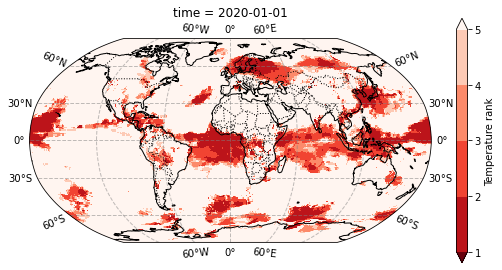

In [19]:
Global_plot(ERA5_jan_rank_inverted)

And zoom in for Siberia. We define a new plot:

In [55]:
def Siberia_plot(ERA5_i_rank_inverted):
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=50.0))
    ERA5_i_rank_inverted.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[1, 2, 3, 4, 5],
        extend='both',
        colors=plt.cm.Reds_r)

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

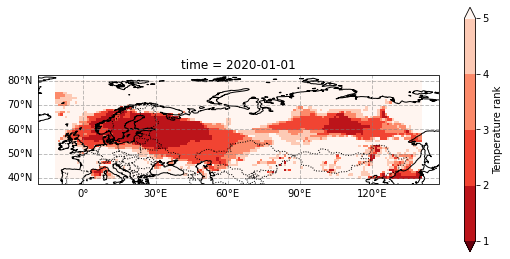

In [56]:
Siberia_plot(ERA5_jan_rank_inverted.sel(longitude = slice(-11,140), latitude = slice(80,40)))

## Loop over Jan-Aug

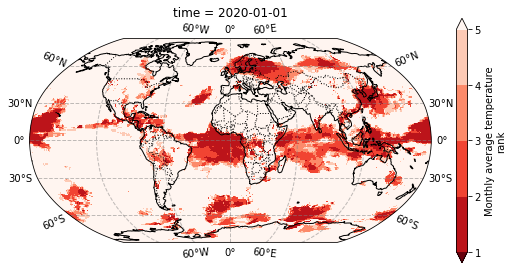

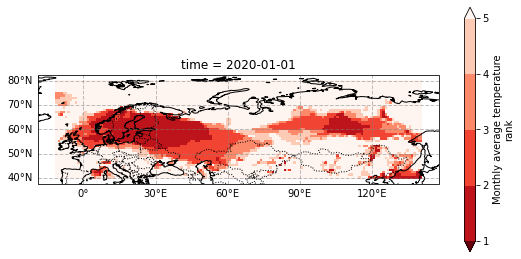

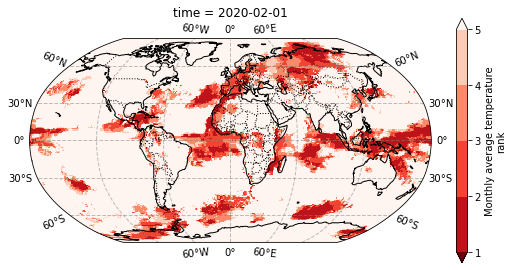

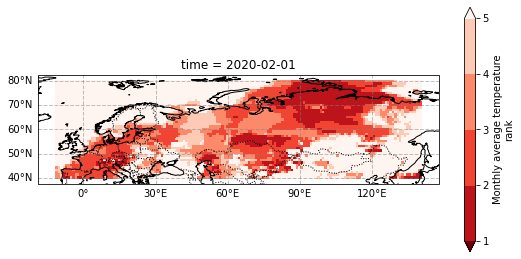

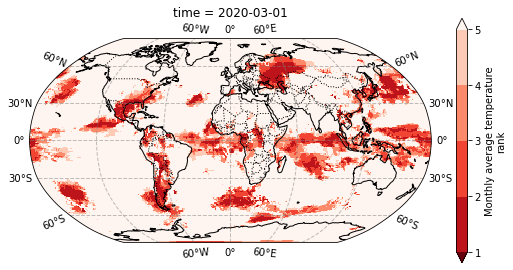

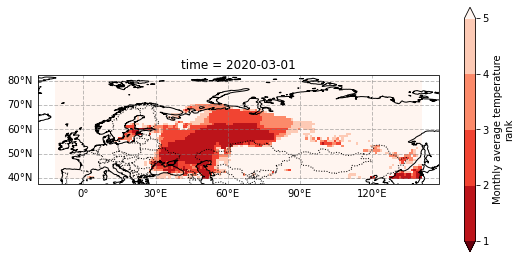

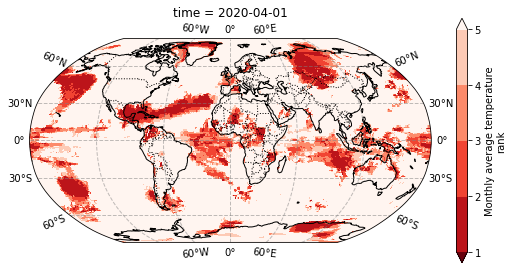

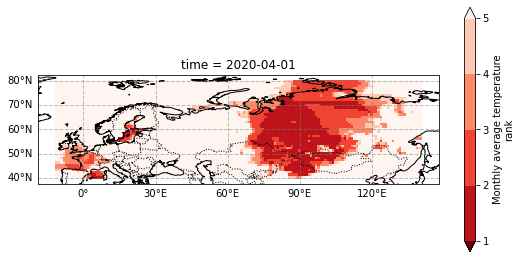

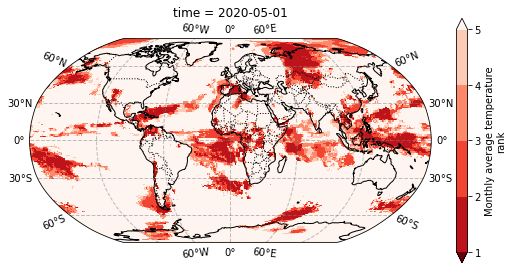

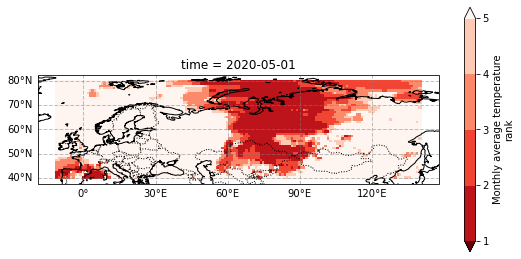

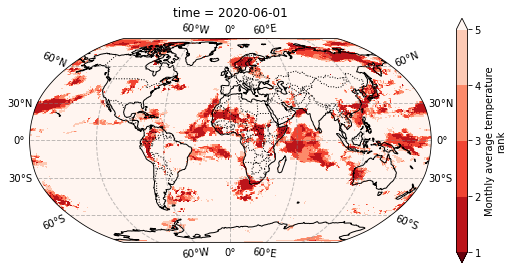

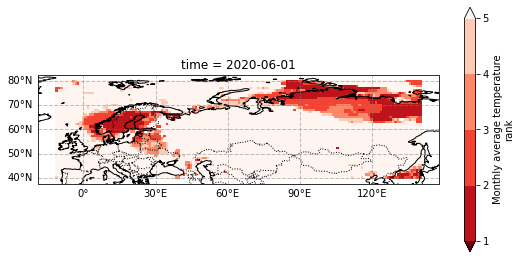

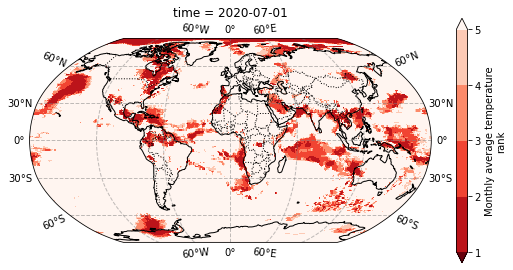

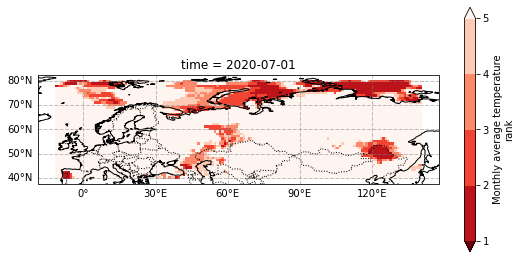

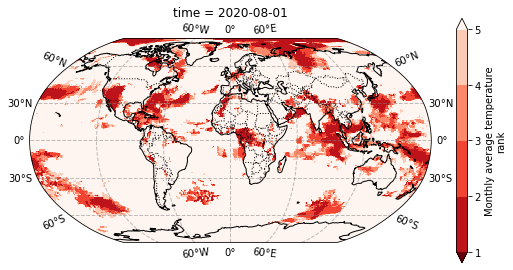

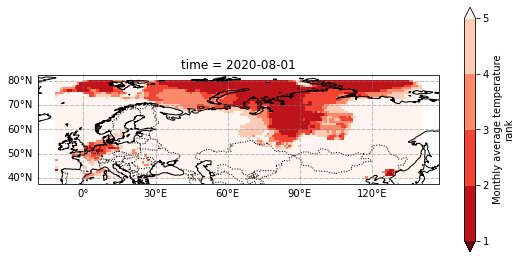

In [57]:
for i in range(1,9):
    ERA5_i = ERA5_combine.sel(time=ERA5_combine['time.month'] == i) ## Select only for the i month
    ERA5_i_rank = ERA5_i['t2m'].rank(dim = 'time')
    ERA5_i_rank = ERA5_i_rank.rename('Monthly average temperature rank')
    ERA5_i_rank_inverted = (len(ERA5_i_rank.time) - ERA5_i_rank + 1).sel(time='2020')
    
    Global_plot(ERA5_i_rank_inverted)
    plt.savefig('../Siberia_example/plots/Global' + str(i) + '.png')

    Siberia_plot(ERA5_i_rank_inverted.sel(longitude = slice(-11,140), latitude = slice(80,40)))
    plt.savefig('../Siberia_example/plots/Siberia' + str(i) + '.png')


## Create the gif

We use ImageMagick and run it from the command line. See this CMS [notebook](https://climate-cms.org/2019/09/03/python-animation.html) for more info on creating gifs. 

In [58]:
!convert -delay 60 ../Siberia_example/plots/Global*png graphs/Global_Animation_01.gif

In [60]:
!convert -delay 60 ../Siberia_example/plots/Siberia*png graphs/Siberia_Animation_01.gif

And show the gif in jupyter notebook with

`![Global Temperature records 2020](../graphs/Global_Animation_01.gif "Records2020")`


![Global Temperature records 2020](../graphs/Global_Animation_01.gif "Records2020")

Same for the Siberian temperature records:
`![Siberian Temperature records 2020](../graphs/Siberia_Animation_01.gif "Records2020")`

![Siberian Temperature records 2020](../graphs/Siberia_Animation_01.gif "Records2020")